# Notebook 6: Working with raster and vector data




## Open the data files

Open the land use raster and the satellite image raster.



In [1]:
# Load libraries
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import rioxarray
import geopandas as gpd


Use rioxarray's [open_rasterio()](https://corteva.github.io/rioxarray/html/rioxarray.html) method to read the TIFF file into an xarray `DataArray`. 

In [2]:
ou_landcover_2021_da = rioxarray.open_rasterio(Path('../data', 'ou_land_cover_2021.tif'))
ou_landcover_2021_da

<xarray.DataArray (band: 1, y: 166, x: 375)> Size: 62kB
[62250 values with dtype=uint8]
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 3kB 1.034e+06 1.034e+06 ... 1.045e+06 1.045e+06
  * y            (y) float64 1kB 2.258e+06 2.258e+06 ... 2.253e+06 2.253e+06
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:        Area
    LAYER_TYPE:           thematic
    OVERVIEWS_ALGORITHM:  IMAGINE Nearest Neighbor Resampling
    scale_factor:         1.0
    add_offset:           0.0
    long_name:            Layer_1

In [38]:
ou_landcover_2021_da.rio.crs

CRS.from_wkt('PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

Now let's open the satellite image.

In [3]:
satellite_image_da = rioxarray.open_rasterio(Path('../data', 'T17TLH_20240401T162831_TCI_10m.tif'))
satellite_image_da

<xarray.DataArray (band: 3, y: 10980, x: 10980)> Size: 362MB
[361681200 values with dtype=uint8]
Coordinates:
  * band         (band) int32 12B 1 2 3
  * x            (x) float64 88kB 3e+05 3e+05 3e+05 ... 4.098e+05 4.098e+05
  * y            (y) float64 88kB 4.8e+06 4.8e+06 4.8e+06 ... 4.69e+06 4.69e+06
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

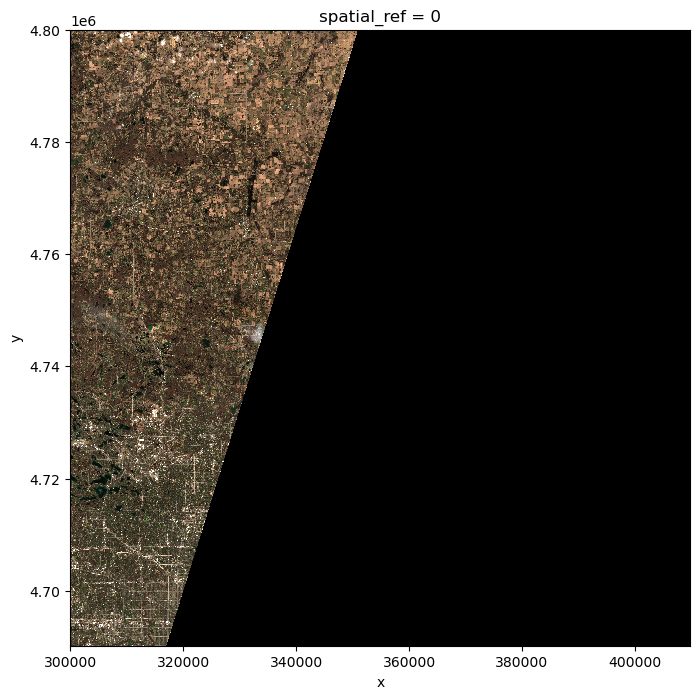

In [4]:
# Visualize it
satellite_image_da.plot.imshow(figsize=(8,8))

## Missing data

From the image above we can see that the actual satellite imagery only takes up a portion of the raster `DataArray`. The black cells do not contain image data. What do they contain? The `_FillValue` attribute tells us that 0 is used for cells which do not contain raster data. We call these, *nodata* values. Sometimes the raster will have its `nodata` attribute set to whatever value is used to indicate no data available. Understanding how nodata values are represented is particularly important when we are computing summary statistics for a raster. In the example above, we wouldn't want to treat all those black cells as valid zero values for any sort of summary statistics of the raster.

Let's see if the `nodata` attribute is set for the satellite image and for the landcover raster.

In [55]:
print(satellite_image_da.rio.nodata)

0

In [56]:
print(ou_landcover_2021_da.rio.nodata)

None


The satellite image uses 0 for its `nodata` value, but, the landcover raster does not have its `nodata` attribute set. We'll revisit this topic later in the notebook. Now let's see what CRS is being used for these two rasters.

In [5]:
ou_landcover_2021_da.rio.crs

CRS.from_wkt('PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [6]:
satellite_image_da.rio.crs

CRS.from_epsg(32617)

In [7]:
satellite_image_da

<xarray.DataArray (band: 3, y: 10980, x: 10980)> Size: 362MB
[361681200 values with dtype=uint8]
Coordinates:
  * band         (band) int32 12B 1 2 3
  * x            (x) float64 88kB 3e+05 3e+05 3e+05 ... 4.098e+05 4.098e+05
  * y            (y) float64 88kB 4.8e+06 4.8e+06 4.8e+06 ... 4.69e+06 4.69e+06
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

We want to use the Albers Equal Area projection and need to reproject the satellite image to this CRS.

In [8]:
satellite_image_aea_da = satellite_image_da.rio.reproject(ou_landcover_2021_da.rio.crs)

<xarray.DataArray (band: 3, y: 12650, x: 12539)> Size: 476MB
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)
Coordinates:
  * x            (x) float64 100kB 1.009e+06 1.009e+06 ... 1.134e+06 1.134e+06
  * y            (y) float64 101kB 2.343e+06 2.343e+06 ... 2.217e+06 2.217e+06
  * band         (band) int32 12B 1 2 3
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     0

In [9]:
satellite_image_aea_da.rio.crs

CRS.from_wkt('PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

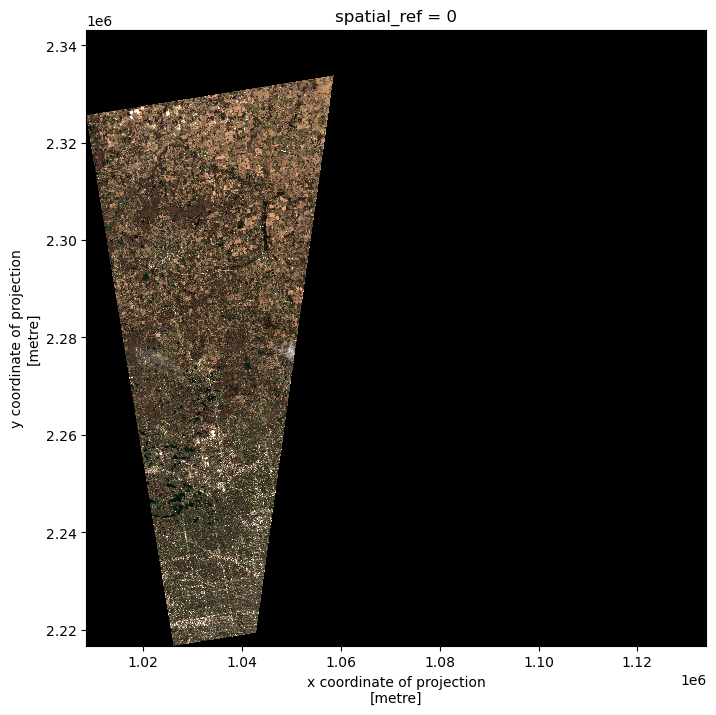

In [11]:
satellite_image_aea_da.plot.imshow(figsize=(8,8))

Now we can clip it to a bounding box.

In [12]:
satellite_image_aea_da.shape

(3, 12650, 12539)

In [13]:
ou_landcover_2021_da.shape

(1, 166, 375)

In [14]:
ou_landcover_2021_da.rio.bounds()

(1034055.0, 2253315.0, 1045305.0, 2258295.0)

In [15]:
satellite_image_aea_clip_da = satellite_image_aea_da.rio.clip_box(*ou_landcover_2021_da.rio.bounds())
print(satellite_image_aea_clip_da.shape)

(3, 499, 1126)


In [16]:
satellite_image_aea_clip_da

<xarray.DataArray (band: 3, y: 499, x: 1126)> Size: 2MB
array([[[138, 128,  89, ..., 103,  78,  50],
        [208, 187, 114, ..., 103,  84,  60],
        [208, 188, 146, ...,  71, 103,  95],
        ...,
        [161, 162, 123, ...,  42,  37,  35],
        [160, 163, 139, ...,  36,  44,  39],
        [146, 161, 149, ...,  47,  49,  48]],

       [[132, 110,  60, ...,  90,  77,  46],
        [190, 163,  89, ...,  90,  79,  47],
        [190, 171, 128, ...,  64,  86,  88],
        ...,
        [147, 137, 105, ...,  44,  45,  42],
        [144, 137, 124, ...,  36,  40,  36],
        [141, 135, 134, ...,  40,  38,  39]],

       [[110,  72,  33, ...,  84,  66,  36],
        [168, 139,  71, ...,  84,  57,  39],
        [168, 136, 100, ...,  55,  69,  78],
        ...,
        [121, 122,  73, ...,  26,  24,  20],
        [118, 120,  95, ...,  23,  24,  22],
        [117, 121, 110, ...,  26,  26,  29]]], dtype=uint8)
Coordinates:
  * x            (x) float64 9kB 1.034e+06 1.034e+06 ... 1.045e+06 1.045e+06
  * y            (y) float64 4kB 2.258e+06 2.258e+06 ... 2.253e+06 2.253e+06
  * band         (band) int32 12B 1 2 3
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     0

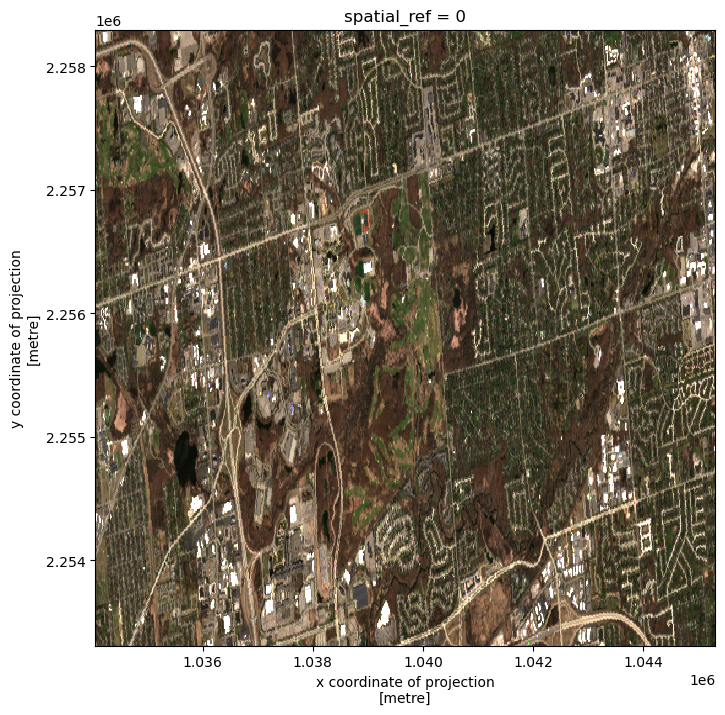

In [17]:
satellite_image_aea_clip_da.plot.imshow(figsize=(8,8))

In [18]:
import cartopy.crs as ccrs 

In [19]:
crs_aea = ccrs.AlbersEqualArea()

In [20]:
# Notice xmin, xmax, ymin, ymax
extent = (ou_landcover_2021_da.rio.bounds()[0], 
                    ou_landcover_2021_da.rio.bounds()[2], 
                    ou_landcover_2021_da.rio.bounds()[1], 
                    ou_landcover_2021_da.rio.bounds()[3])

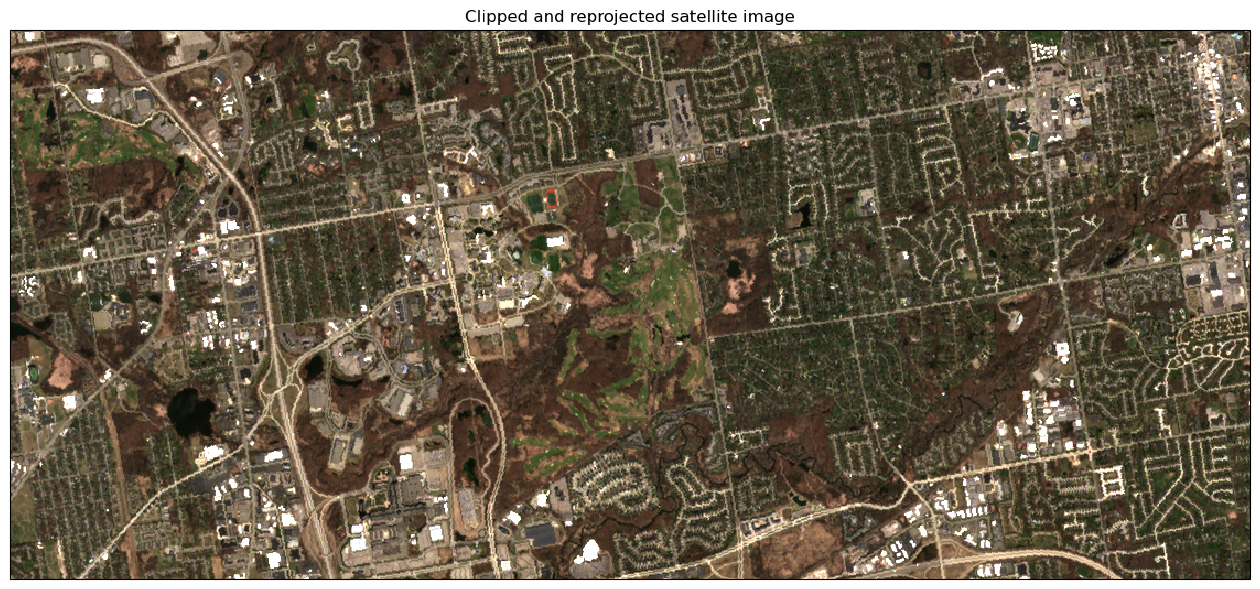

In [21]:
# Create figure and set size
fig1 = plt.figure()
fig1.set_figheight(9)
fig1.set_figwidth(16)

# create a set of axes with desired projection  
ax1 = plt.axes(projection = crs_aea)

# Set map extent
ax1.set_extent(extent, crs = crs_aea)

# Add land use raster
satellite_image_aea_clip_da.plot.imshow(ax=ax1)

ax1.set_title("Clipped and reprojected satellite image")                    
plt.show()

In [22]:
satellite_image_aea_clip_da.rio.to_raster("../data/satellite_image_aea_clip_da.tif")

## Clip raster using reproject_match

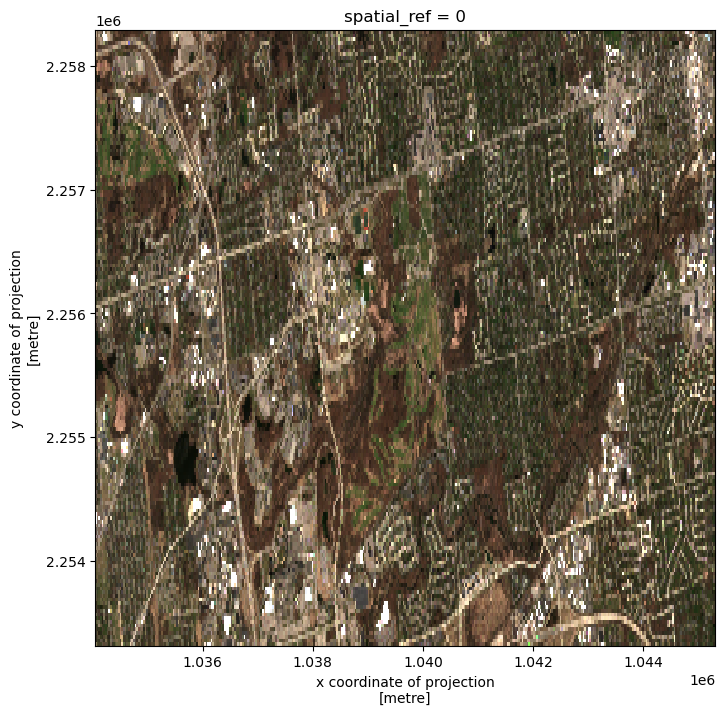

In [23]:
satellite_image_reproject_match = satellite_image_da.rio.reproject_match(ou_landcover_2021_da)
satellite_image_reproject_match.plot.imshow(figsize=(8,8))

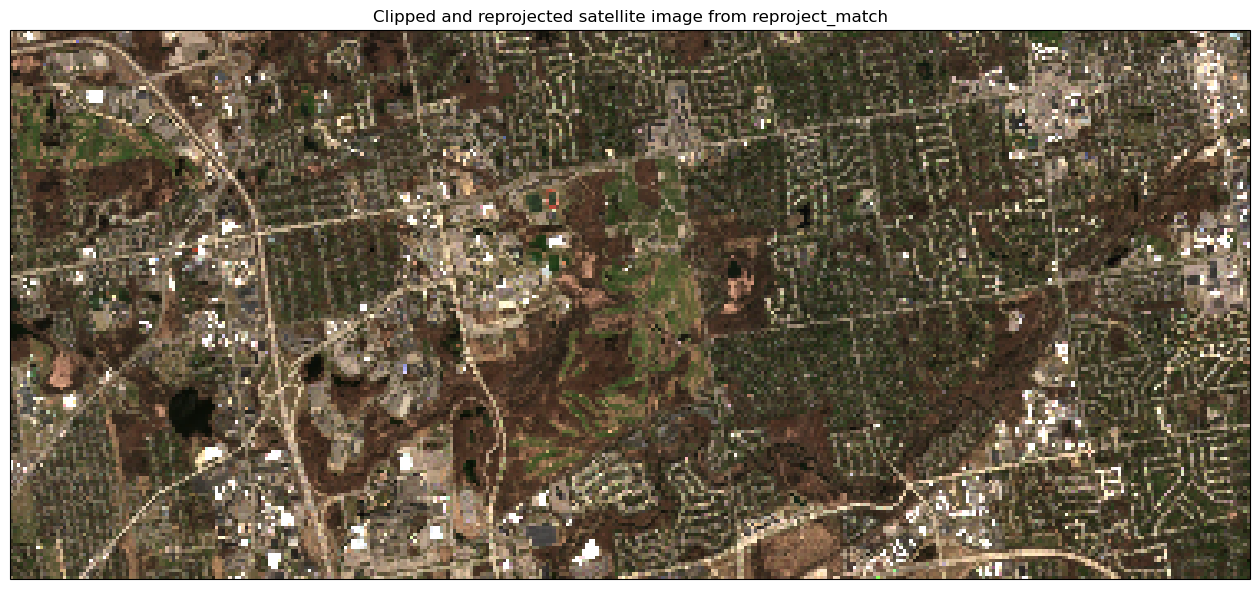

In [24]:
# Create figure and set size
fig1 = plt.figure()
fig1.set_figheight(9)
fig1.set_figwidth(16)

# create a set of axes with desired projection  
ax1 = plt.axes(projection = crs_aea)

# Set map extent
ax1.set_extent(extent, crs = crs_aea)

# Add land use raster
satellite_image_reproject_match.plot.imshow(ax=ax1)

ax1.set_title("Clipped and reprojected satellite image from reproject_match")                    
plt.show()

As we can see from [the documentation for reproject_match](https://corteva.github.io/rioxarray/stable/rioxarray.html#rioxarray.raster_array.RasterArray.reproject_match), it also matches the resolution. Since the land use raster had lower resolution (larger pixel size), the new satellite image has been *resampled* to match it. Resampling is another common raster operation. Reprojection is a specific type of resampling when the target CRS differs from the source CRS. There are different *upsampling* and *downsampling* methodds. The Geocomputation with Python book has all the details.

- https://rasterio.readthedocs.io/en/latest/topics/resampling.html
- https://py.geocompx.org/04-geometry-operations#sec-raster-resampling

## Clip to a polygon

In [25]:
ou_boundary_file = Path('../data', 'ou_boundary.geojson')
ou_boundary_gdf = gpd.read_file(ou_boundary_file)

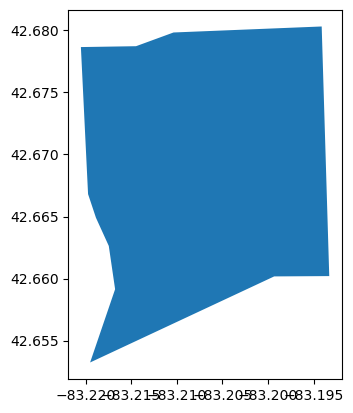

In [26]:
ou_boundary_gdf.plot();

In [27]:
ou_boundary_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   fid       1 non-null      int64   
 1   geometry  1 non-null      geometry
dtypes: geometry(1), int64(1)
memory usage: 144.0 bytes


In [28]:
from pyproj import CRS

One of the things we can do with a `pyproj.CRS` object is get a WKT representation of it using the `to_wkt()` method. The WKT representation contains a wealth of detailed data that define a projection.

In [29]:
crs_land_use_raster = ou_landcover_2021_da.rio.crs

In [30]:
crs_land_use_raster.to_wkt()

'PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

Now we can use this existing `CRS` object to specify the destination CRS for our vector data.

In [31]:
ou_boundary_aea_gdf = ou_boundary_gdf.to_crs(crs_land_use_raster)

In [32]:
satellite_image_clip_ou = satellite_image_aea_clip_da.rio.clip(ou_boundary_aea_gdf['geometry'])

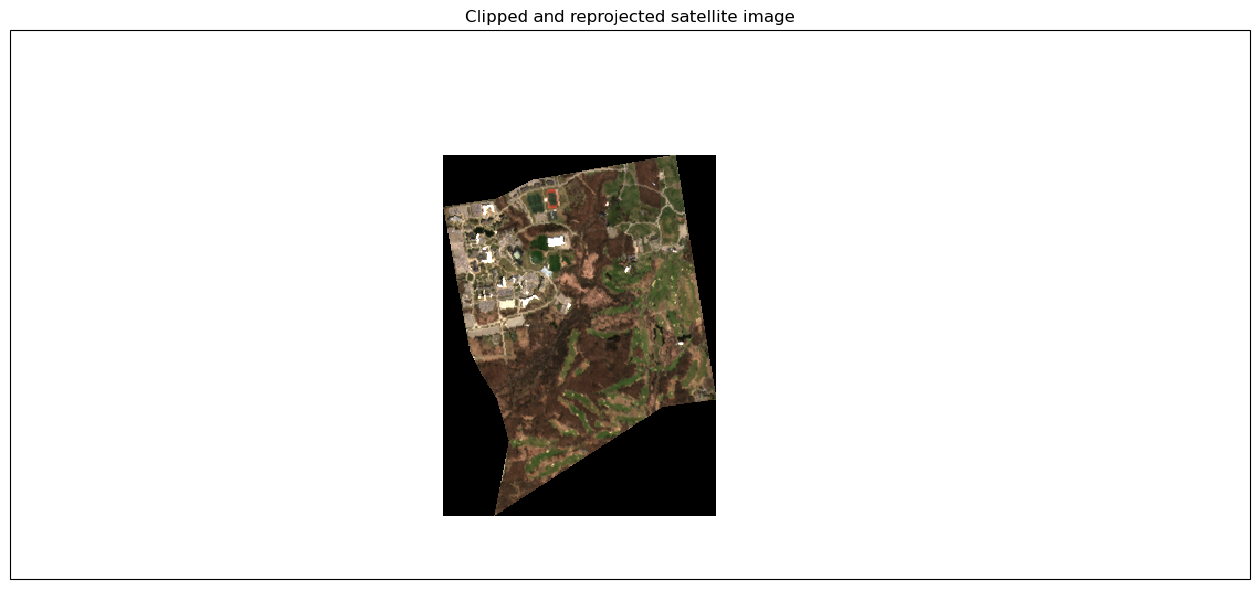

In [33]:
# Create figure and set size
fig1 = plt.figure()
fig1.set_figheight(9)
fig1.set_figwidth(16)

# create a set of axes with desired projection  
ax1 = plt.axes(projection = crs_aea)

# Set map extent
ax1.set_extent(extent, crs = crs_aea)

# Add land use raster
satellite_image_clip_ou.plot.imshow(ax=ax1)

ax1.set_title("Clipped and reprojected satellite image of OU campus")                    
plt.show()

In [34]:
satellite_image_clip_ou

<xarray.DataArray (band: 3, y: 327, x: 247)> Size: 242kB
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)
Coordinates:
  * x            (x) float64 2kB 1.038e+06 1.038e+06 ... 1.04e+06 1.04e+06
  * y            (y) float64 3kB 2.257e+06 2.257e+06 ... 2.254e+06 2.254e+06
  * band         (band) int32 12B 1 2 3
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     0

Let's do the same clipping for the landcover raster.

In [44]:
landcover_2021_clip_ou = ou_landcover_2021_da.rio.clip(ou_boundary_aea_gdf['geometry'])

C:\Users\isken\Anaconda3\envs\geonewb\lib\site-packages\xarray\core\duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


Let's plot the clipped landcover raster using the custom color map we developed back in the very first notebook on rasters.

In [48]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

In [49]:
# Raster matrix
A = landcover_2021_clip_ou[0]

# Define the discrete values and their corresponding colors
col_dict = {
    11: 'dodgerblue',
    21: 'gainsboro',
    22: 'lightgrey',
    23: 'darkgrey',
    24: 'grey',
    31: 'sandybrown',
    41: 'forestgreen',
    42: 'green',
    43: 'darkgreen',
    52: 'olivedrab',
    71: 'lawngreen',
    81: 'yellow',
    82: 'gold',
    90: 'greenyellow',
    95: 'darkseagreen'
}

# Create a colormap from our list of colors
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

# Let's also define the description of each category 
labels = np.array(["Open Water", "Dev-Open", "Dev-Low", "Dev-Med", "Dev-High",
                  "Barren", "Deciduous", "Evergreen", "43", "Shrub/Scrub", 
                  "Grassland/Herbaceous",
                  "Pasture", "Crops", "Woody Wetlands", "Emerg Herb Wetlands"])
len_lab = len(labels)

# prepare normalizer
# Prepare bins for the normalizer
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
# Make normalizer 
norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)

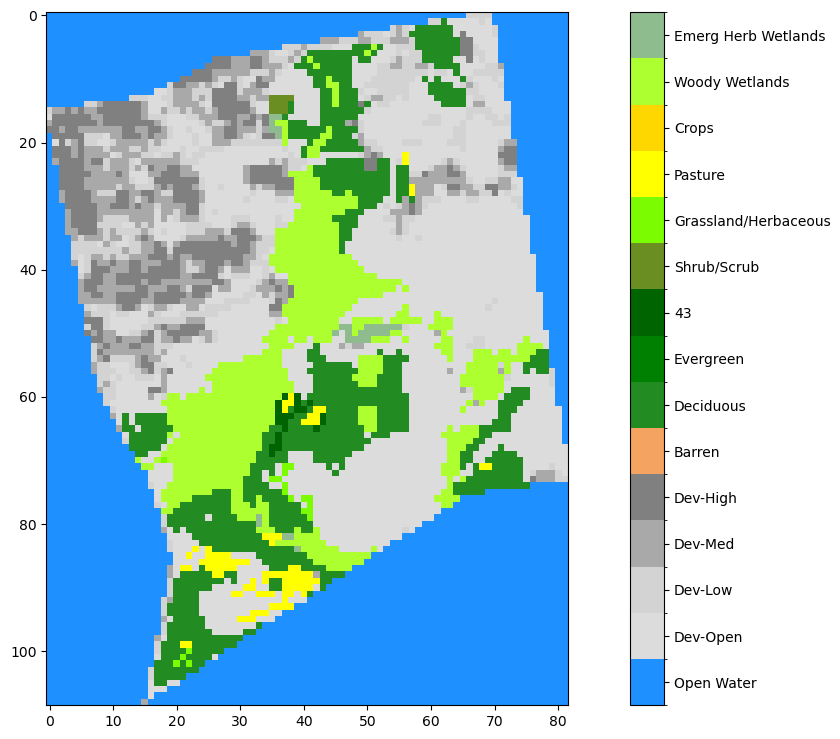

In [50]:
# Create the tick label formatter. The pos argument is required per the API.
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos=None: labels[norm(x)])

# Plot our figure
fig, ax = plt.subplots()

fig.set_figheight(9)
fig.set_figwidth(16)

im = ax.imshow(A, cmap=cm, norm=norm)

# Create the associated colorbar
diff = norm_bins[1:] - norm_bins[:-1] # Compute bin size
tickz = norm_bins[:-1] + diff / 2     # Compute tick position at midpoint of bin
cb = fig.colorbar(im, format=fmt, ticks=tickz)
plt.show()

## nodata values revisited

According to our color bar, the OU campus is surrounded by open water! Of course, that's not really true. This is a nodata issue. If we look at the color bar boundaries, we see that any raster values less than 10.5 are getting classified into the first color category. But, the nodata value is 0 and we don't want these classified as open water. There are few ways of dealing with this:

- convert the 0 values to `np.nan` values,
- use the xarray `where` function to select a subset of the raster to plot,
- set the `nodata` attribute of this raster and use what is known as *masking* when loading the raster.

In [51]:
print(norm.boundaries)

[10.5 11.5 21.5 22.5 23.5 24.5 31.5 41.5 42.5 43.5 52.5 71.5 81.5 82.5
 90.5 95.5]


In [52]:
landcover_2021_clip_ou

<xarray.DataArray (band: 1, y: 109, x: 82)> Size: 9kB
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 656B 1.038e+06 1.038e+06 ... 1.04e+06 1.04e+06
  * y            (y) float64 872B 2.257e+06 2.257e+06 ... 2.254e+06 2.254e+06
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:        Area
    LAYER_TYPE:           thematic
    OVERVIEWS_ALGORITHM:  IMAGINE Nearest Neighbor Resampling
    scale_factor:         1.0
    add_offset:           0.0
    long_name:            Layer_1

We'll use `where` to subset the raster and just plot the pixels that are not equal to 0.

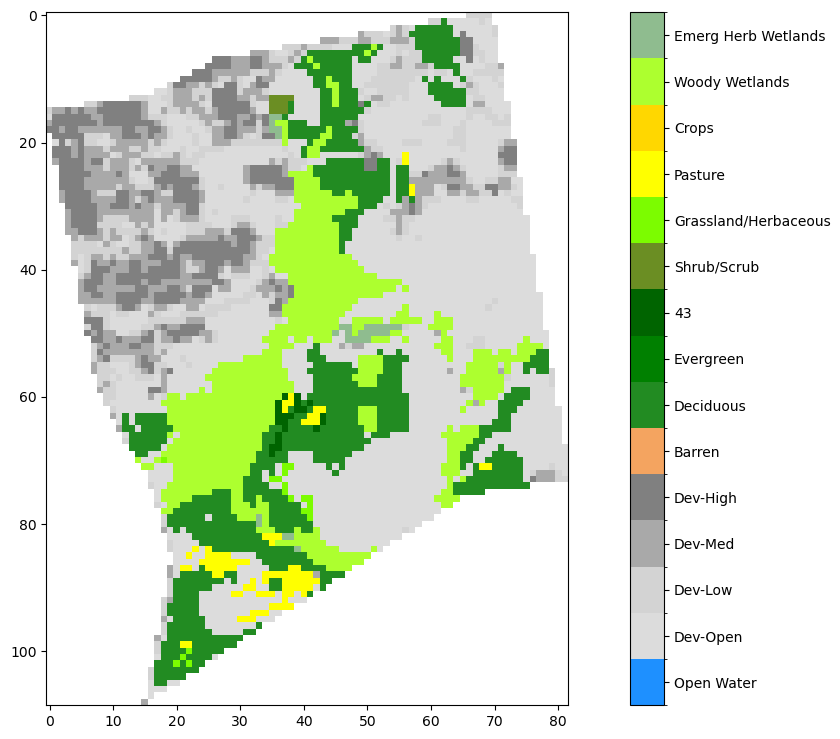

In [57]:
# Plot our figure
fig, ax = plt.subplots()

fig.set_figheight(9)
fig.set_figwidth(16)

im = ax.imshow(A.where(A!=0), cmap=cm, norm=norm)

# Create the associated colorbar
cb = fig.colorbar(im, format=fmt, ticks=tickz)
plt.show()

## Doing raster calculations

We often want to combine values of and perform calculations on rasters to create a new output raster. A common example is the computation of some sort of index such as the NDVI.

### Normalized Difference Vegetation Index (NDVI)
Suppose we are interested in monitoring vegetation fluctuations using satellite remote sensors. Scientists have defined
a vegetation index to quantify the amount of green leaf vegetation using the light reflected in different wavelengths.
This index, named Normalized Difference Vegetation Index (NDVI), exploits the fact that healthy green leaves strongly
absorb red visible light while they mostly reflect light in the near infrared (NIR). The NDVI is computed as:

$$ NDVI = \frac{NIR - red}{NIR + red} $$

where $NIR$ and $red$ label the reflectance values of the corresponding wavelengths. NDVI values range from -1 to +1.
Values close to one indicate high density of green leaves. Poorly vegetated areas typically have NDVI values close to
zero. Negative NDVI values often indicate cloud and water bodies.

![Source: Wu C-D, McNeely E, Cedeño-Laurent JG, Pan W-C, Adamkiewicz G, Dominici F, et al. (2014) Linking Student Performance in Massachusetts Elementary Schools with the “Greenness” of School Surroundings Using Remote Sensing. PLoS ONE 9(10): e108548. https://doi.org/10.1371/journal.pone.0108548](fig/E09/PONE-NDVI.jpg){alt="PONE-NDVI image"}

It would seem that the NDVI based raster might be somewhat similar to the land cover raster in terms of overall patterns. NDVI is a continuous value and land cover is a categorical raster. However, we can always create an NDVI binning scheme to convert it to discrete values if we want.


### Computing NDVI

Recall that we saved the NIR band as a local TIFF in the previous notebook. When we read this file into a `DataArray`, we'll use the `squeeze()` function to get rid of the single band dimension.

We can pull the red band from the satellite image we have been working with in this notebook.

In [61]:
nir_da = rioxarray.open_rasterio(Path('../data', 'T17TLH_20240401T162831_B08_10m.tif')).squeeze()
print(nir_da.rio.crs)
nir_da

EPSG:32617


<xarray.DataArray (y: 10980, x: 10980)> Size: 241MB
[120560400 values with dtype=uint16]
Coordinates:
    band         int32 4B 1
  * x            (x) float64 88kB 3e+05 3e+05 3e+05 ... 4.098e+05 4.098e+05
  * y            (y) float64 88kB 4.8e+06 4.8e+06 4.8e+06 ... 4.69e+06 4.69e+06
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

The red band is the first of the three bands in the satellite image. We are going to use the image that has already been clipped to the boundaries of the OU campus.

In [62]:
red_da = satellite_image_clip_ou[0]

Before we can calculate NDVI, we need to make sure we reproject it to the same CRS as in the satellite image.

In [63]:
nir_da = nir_da.rio.reproject_match(red_da)

In [69]:
print(red_da.rio.bounds())
print(nir_da.rio.bounds())

print(red_da.rio.crs == nir_da.rio.crs)

print(red_da.rio.nodata)
print(nir_da.rio.nodata)

(1037980.4356346613, 2253889.5618593586, 1040450.2416667741, 2257159.3050678642)
(1037980.4356346613, 2253889.5618593586, 1040450.2416667741, 2257159.3050678642)
True
0
0


Let's convert the nodata values to `np.nan`.

In [71]:
red_da[red_da == 0] = np.nan
nir_da[nir_da == 0] = np.nan

IndexError: 2-dimensional boolean indexing is not supported. 

Ok, the two rasters are *aligned* and now we can do mathematical vector operations such as the subtraction and division needed to compute NDVI.

In [67]:
ndvi_da = (nir_da - red_da)/(nir_da + red_da)

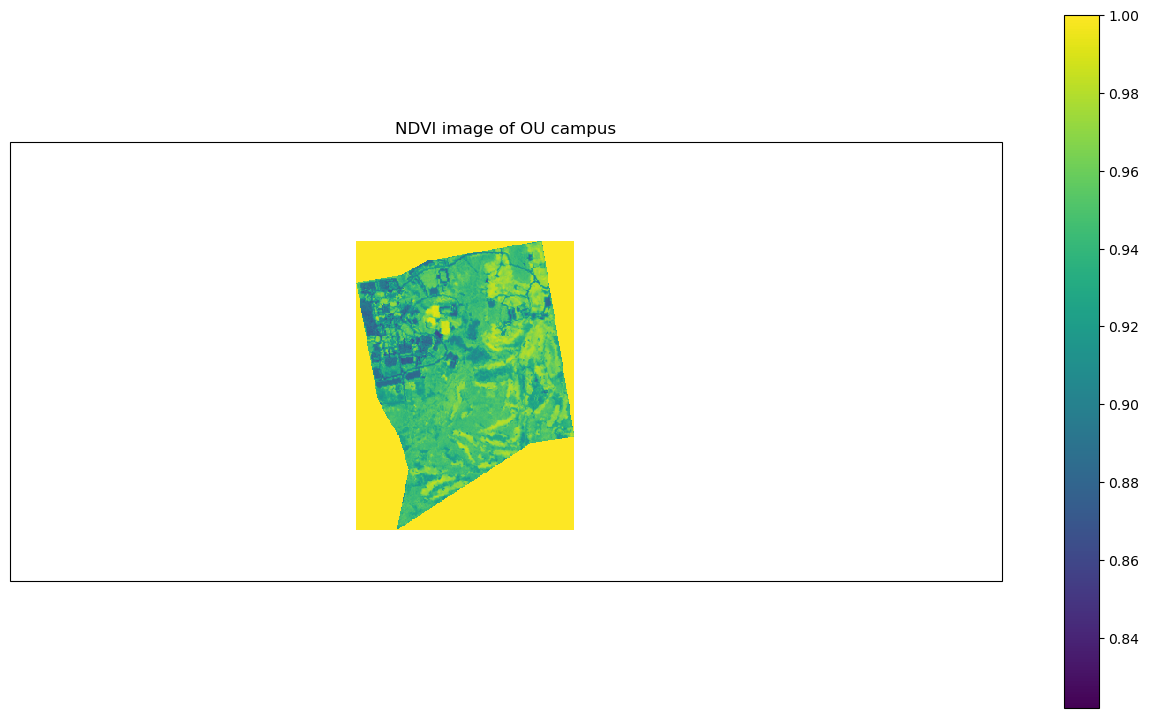

In [68]:
# Create figure and set size
fig1 = plt.figure()
fig1.set_figheight(9)
fig1.set_figwidth(16)

# create a set of axes with desired projection  
ax1 = plt.axes(projection = crs_aea)

# Set map extent
ax1.set_extent(extent, crs = crs_aea)

# Add land use raster
ndvi_da.plot.imshow(ax=ax1)

ax1.set_title("NDVI image of OU campus")                    
plt.show()

In [ ]:
print(ou_places_aea_gdf.crs)
print(ou_boundary_aea_gdf.crs)

## Plotting the data

Let's plot these the two vector dataframes. They should overlap.

GeoPandas has a built in `plot()` function that operates on `GeoDataFrames. See [https://geopandas.org/en/stable/docs/user_guide/mapping.html](https://geopandas.org/en/stable/docs/user_guide/mapping.html) for all the details. Most of the options are standard matplotlib things for controlling details of the plot appearance.

### Challenge: Plot the two vector `GeoDataFrames`

In [ ]:
# Plot vector dataframes


### Answer

<Axes: >

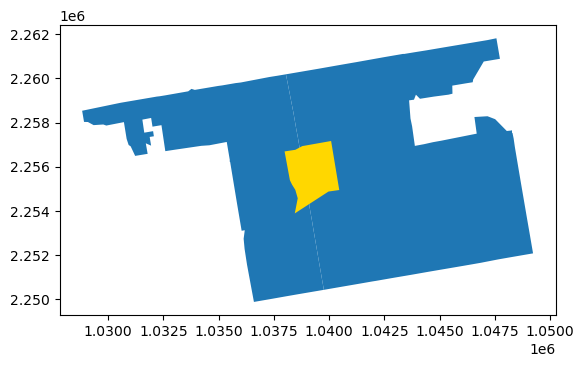

In [22]:
fig, ax = plt.subplots()
ou_places_aea_gdf.plot(ax=ax)
ou_boundary_aea_gdf.plot(ax=ax, color='gold')

The plot reveals something interesting. The OU campus straddles the border between Auburn Hills and Rochester Hills. 

### Combining raster and vector data in a plot

Let's try adding the land use raster to our plot. Remember, this raster contains a bunch of area surrounding the OU campus, but doesn't contain all of Auburn Hills and Rochester Hills.

A few things to note in the code below:

- use the `alpha` parameter to control transparency of the different levels,
- use the `zorder` parameter to control how the layers stacked (`zorder=1` is the bottom layer).

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

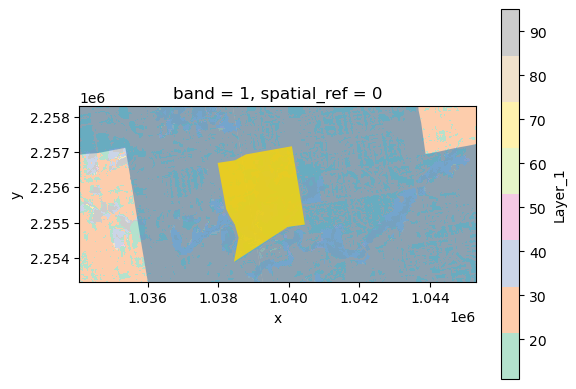

In [18]:
fig, ax = plt.subplots()
ou_landcover_2021_da.plot(ax=ax, cmap='Pastel2', zorder=1)
ou_places_aea_gdf.plot(ax=ax, alpha=0.5, zorder=2)
ou_boundary_aea_gdf.plot(ax=ax, color='gold', alpha=0.8, zorder=3)


Seems like the default extent is being controlled by the size of the raster. Another option for geospatial plotting in Python is the [Cartopy](http://scitools.org.uk/cartopy/docs/latest/) package.

From the [Cartopy docs](https://scitools.org.uk/cartopy/docs/latest/):

> - Cartopy is a Python package designed for geospatial data processing in order to produce maps and other geospatial data analyses.
>
> - Cartopy makes use of the powerful PROJ, NumPy and Shapely libraries and includes a programmatic interface built on top of Matplotlib for the creation of publication quality maps.
>
> - Key features of cartopy are its object oriented projection definitions, and its ability to transform points, lines, vectors, polygons and images between those projections.
>
> - You will find cartopy especially useful for large area / small scale data, where Cartesian assumptions of spherical data traditionally break down. If you’ve ever experienced a singularity at the pole or a cut-off at the dateline, it is likely you will appreciate cartopy’s unique features!

We won't go into much detail with Cartopy right now.

In [15]:
import cartopy.crs as ccrs                   # import projections

We'll create a CRS object for our Albers projections. This will get used when we create the plot axes.

In [16]:
crs_aea = ccrs.AlbersEqualArea()

Cartopy makes it easy to set the map extent using a bounding box. However, it wants the elements of the box in a slightly different order than what we've used previously. Cartopy specifies extents with **(xmin, xmax, ymin, ymax)**. We can use the `ou_places_aea_gdf` dataframe as the basis for our extent,

In [17]:
# Notice xmin, ymin, xmax, ymax
ou_places_aea_gdf.total_bounds

array([1028821.72370821, 2249882.28354187, 1049224.58562468,
       2261812.53566168])

In [18]:
# Notice xmin, xmax, ymin, ymax
ou_places_extent = (ou_places_aea_gdf.total_bounds[0], 
                    ou_places_aea_gdf.total_bounds[2], 
                    ou_places_aea_gdf.total_bounds[1], 
                    ou_places_aea_gdf.total_bounds[3])

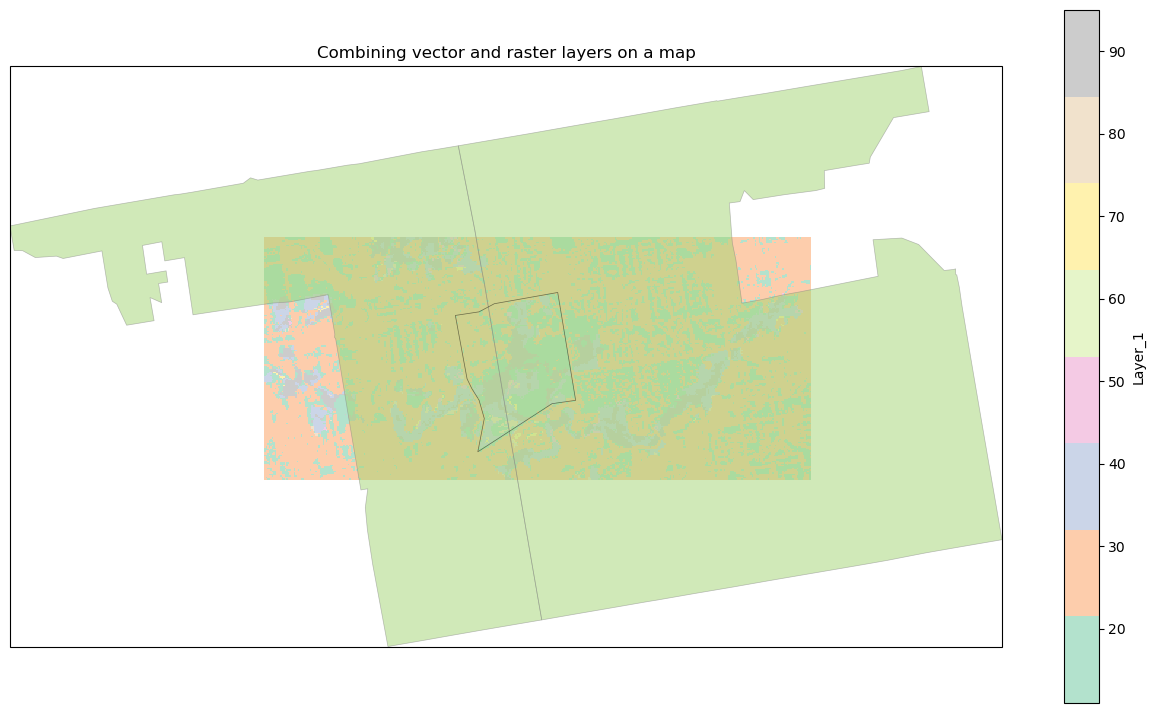

In [19]:
# Create figure and set size
fig1 = plt.figure()
fig1.set_figheight(9)
fig1.set_figwidth(16)

# create a set of axes with desired projection  
ax1 = plt.axes(projection = crs_aea)

# Set map extent
ax1.set_extent(ou_places_extent, crs = crs_aea)

# Add vectors
ax1.add_geometries(ou_places_aea_gdf.geometry, crs=crs_aea, 
                   facecolor="#a2d572", edgecolor="grey", linewidth=0.5, alpha=0.5) 
ax1.add_geometries(ou_boundary_aea_gdf.geometry, facecolor="none", crs=crs_aea, edgecolor="black", linewidth=0.5, alpha=0.5) 

# Add land use raster
ou_landcover_2021_da.plot(ax=ax1, cmap='Pastel2')

ax1.set_title("Combining vector and raster layers on a map")                    
plt.show()

The reprojections seem to have worked as we can see the raster and both vector layers on our plot. Obviously, more work is needed to make this usable. In later sections we'll learn how to clip data layers to just include the data we want to plot as well to fine tune our maps.